# **Homework - Lab 3**
#### Szymon Pająk


## **Physical problem**

The **advection-diffusion equation** models the transport of a scalar quantity (like heat, pollutants, or chemical concentration) under the combined effects of **advection** (transport due to flow) and **diffusion** (spreading due to molecular motion). It appears in many areas of science and engineering, such as fluid dynamics, environmental modeling, and chemical engineering.

In one spatial dimension, the advection-diffusion equation is given by:

$$
\frac{\partial C}{\partial t} + u \frac{\partial C}{\partial x} = D \frac{\partial^2 C}{\partial x^2}
$$

where:
- $C(x, t)$ is the scalar concentration field (e.g., temperature or pollutant),
- $u$ is the **constant advection velocity** (positive for rightward transport),
- $D$ is the **diffusion coefficient**, representing the rate of spreading,
- $x$ is the spatial coordinate, and $t$ is time.

This equation balances two physical processes:
1. **Advection**: the term $u \frac{\partial C}{\partial x}$ transports the scalar field along the direction of flow.
2. **Diffusion**: the term $D \frac{\partial^2 C}{\partial x^2}$ smooths out gradients due to random motion or molecular mixing.

In this notebook, we consider a **simple initial condition**:

$$
C(x, 0) = \sin(\pi x)
$$

with boundary conditions $C(0,t) = C(1,t) = 0$. This setup could represent, for example, the distribution of a pollutant in a 1-meter-long pipe that is initially sinusoidally distributed and then evolves over time due to flow (advection) and mixing (diffusion).

We solve this problem:
- **Analytically**, using the known solution to the equation with sinusoidal initial data.
- **Numerically**, using an **upwind finite difference scheme** that captures the directional nature of the flow while accounting for diffusion.

Comparing the numerical and analytical results allows us to assess the accuracy of the numerical scheme and understand the behavior of the advection-diffusion process.



## **Implementation**

In [34]:
import numpy as np
import matplotlib.pyplot as plt

In [35]:
class shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub

    def __radd__(self, o):
        return slice(o.start + self.add, o.stop + self.add)

    def __rsub__(self, o):
        return slice(o.start - self.sub, o.stop - self.sub)

class AnalyticalAdvectionDiffusion:
    def __init__(self, velocity, diffusivity):
        self.u = velocity
        self.D = diffusivity

    def evaluate(self, x, t):
        return np.exp(-(np.square(self.u) / (4 * self.D) + np.square(np.pi) * self.D) * t) * np.sin(np.pi * x)

class UpwindSolver:
    def __init__(self, domain_length, time_end, nx, nt, velocity, diffusivity):
        self.L = domain_length
        self.T = time_end
        self.nx = nx
        self.nt = nt
        self.u = velocity
        self.D = diffusivity

        self.dx = self.L / (self.nx - 1)
        self.dt = self.T / self.nt
        self.x = np.linspace(0, self.L, self.nx)

        self.analytical = AnalyticalAdvectionDiffusion(velocity=self.u, diffusivity=self.D)

        # Initialize shifts for neighbor indexing
        self.one = shift(add=1, sub=1)
        self.hlf = shift(add=0, sub=1)

    def run(self):
        # Courant number
        C = self.u * self.dt / self.dx
        alpha = self.D * self.dt / (self.dx**2)

        phi = self.analytical.evaluate(self.x, 0)
        phi_new = phi.copy()

        # Loop over time steps
        for _ in range(self.nt):
            for i in range(1, self.nx - 1):
                advection = C * (phi[i] - phi[i - 1])
                diffusion = alpha * (phi[i + 1] - 2 * phi[i] + phi[i - 1])
                phi_new[i] = phi[i] - advection + diffusion

            phi[:] = phi_new[:]  # Update the solution for the next time step

        return phi

    def exact(self, t):
        return self.analytical.evaluate(self.x, t)

In [36]:
# --- Comparison and Plotting ---
def mean_relative_error(y_exact, y_numeric):
    eps = 1e-12  # Avoid division by zero
    return np.mean(np.abs((y_exact[1:-1] - y_numeric[1:-1]) / (y_exact[1:-1] + eps)))

def plot_results(x, initial, numerical, analytical, title):
    plt.figure(figsize=(8, 5))
    plt.step(x, initial, where='mid', label='Initial condition')
    plt.step(x, analytical, where='mid', label='Analytical solution')
    plt.step(x, numerical, where='mid', label='Numerical (Upwind)')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('Concentration')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [37]:
# Parameters
L = 1.0
T = 5.0
nx = 100
nt = 1500
u = 0.02
D = 0.01

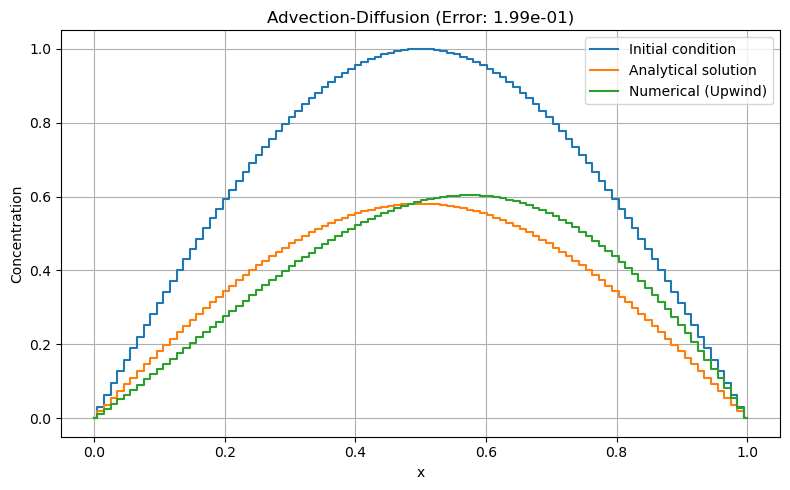

In [38]:
solver = UpwindSolver(domain_length=L, time_end=T, nx=nx, nt=nt, velocity=u, diffusivity=D)

phi_numerical = solver.run()
phi_exact = solver.exact(T)
phi_initial = solver.exact(0)

error = mean_relative_error(phi_exact, phi_numerical)

plot_results(solver.x, phi_initial, phi_numerical, phi_exact,
             f"Advection-Diffusion (Error: {error:.2e})")


## **Conclusions**

The numerical simulation using the upwind scheme successfully captures the behavior of the advection-diffusion process. When compared to the analytical solution, the numerical results show good agreement, especially in regions where the solution varies smoothly.

The step-like nature of the upwind method introduces some numerical diffusion, which slightly damps the solution amplitude over time. This is expected, particularly for low-order schemes and when the Courant number approaches the stability limit.

The **mean relative error** between the analytical and numerical solutions provides a quantitative measure of accuracy, and the visual comparison confirms that the numerical method is suitable for modeling transport phenomena where moderate accuracy is acceptable.
